# QAOA data and analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import json
from collections import Counter
from time import perf_counter

mpl.rcParams.update({'errorbar.capsize' : 3})

## Analysis functions

In [2]:
def computeTrueMaxCut(G):  
    #Uses Gurobi solver
    t_start = perf_counter()
    N = len(G)
    m = gp.Model()
    m.Params.LogToConsole = 0 #suppress noisy output
    x = m.addMVar(shape = N, vtype=GRB.BINARY, name = 'x')
    adj = nx.linalg.adjacency_matrix(G, nodelist = list(range(N)))
    edge_sum = G.size(weight='weight')
    m.setObjective((1/2)*edge_sum-(1/4)* (2*x - np.ones(N)) @ adj @ (2*x - np.ones(N)), GRB.MAXIMIZE)
    m.optimize()
    t_end = perf_counter()

    return m.ObjVal, t_end - t_start

def computeCutVal(G, bitstring):
    val = 0
    for (i,j) in G.edges():
        if bitstring[i] != bitstring[j]:
            val -= 1
    return val


def reverse_percentile_bootstrap(G, results):
    energy_errs = np.zeros((2,len(results)))
    for i,res in enumerate(results.values()):
        shots = len(res)
        counts_dict = dict(Counter(res))
        probs_dict = {k: v/shots for (k,v) in counts_dict.items()}
        measured_bs = probs_dict.keys()
        measured_energies = [computeCutVal(G,bs) for bs in measured_bs]
        corresp_probs = [probs_dict[key] for key in measured_bs]
        resamples = []
        n_resamples = 100
        for _ in range(n_resamples):
            resample = np.mean(np.random.choice(measured_energies, size = shots, p = corresp_probs))
            resamples.append(resample)

        resample_mean = np.mean(resamples)
        true_sample_mean = np.average(measured_energies, weights = corresp_probs)
        sigma = np.std(resamples, ddof = 1)

        tm = 2*true_sample_mean #twice mean
        lower = np.percentile(resamples, 15.865525393) #1 sigma percentile (lower)
        upper = np.percentile(resamples, 100-15.865525393) #1 sigma percentile (upper)
        L = tm - upper
        U = tm - lower
        energy_errs[0,i] = true_sample_mean - L
        energy_errs[1,i] = U - true_sample_mean
    return energy_errs

## Load data

In [3]:
with open('data/QAOA_N32_p2_Experiment.json', 'r') as f: 
    save_dict = json.load(f)
N32results = save_dict['exp_results'] #Note: bitstrings have been reversed relative to the machine results to align with graph node ordering
N32params = np.array(save_dict['params'])
N32qasm = save_dict['qasm']
N32graph = nx.from_edgelist(save_dict['graph'])

In [4]:
with open('data/QAOA_N130_p1_Reuse_Experiment.json', 'r') as f: 
    save_dict = json.load(f)
N130results = save_dict['exp_results'] #Note: bitstrings have been reversed relative to the machine results to align with graph node ordering
N130params = np.array(save_dict['params'])
N130qasm = save_dict['qasm']
N130graph = nx.from_edgelist(save_dict['graph'])

In [5]:
with open('data/QAOA_N130_p1_Landscape.json', 'r') as f: 
    save_dict = json.load(f)
landscape = save_dict['landscape']

In [6]:
with open('data/Quimb_Bayesian_Optimization.json', 'r') as f: 
    save_dict = json.load(f)
N32_quimb_best_val_p1 = np.min(save_dict['quimb_results']['N32p1'])
N32_quimb_best_val_p2 = np.min(save_dict['quimb_results']['N32p2'])
N130_quimb_best_val = np.min(save_dict['quimb_results']['N130p1'])

In [7]:
N32MaxCut = computeTrueMaxCut(N32graph)
print(N32MaxCut)

Restricted license - for non-production use only - expires 2024-10-28
(42.0, 0.22496031400000005)


In [8]:
N130MaxCut = computeTrueMaxCut(N130graph)
print(N130MaxCut)

(178.0, 0.1757040270000001)


In [9]:
N32CutVals = {i : [computeCutVal(N32graph, bs) for bs in N32results[str(i)]] for i in range(len(N32results))}
N32ObjectiveTrajectory = [np.mean(cutvals) for cutvals in N32CutVals.values()]
N32BestEachEval = [np.min(cutvals) for cutvals in N32CutVals.values()]
N130CutVals = {i : [computeCutVal(N130graph, bs) for bs in N130results[str(i)]] for i in range(len(N130results))}
N130ObjectiveTrajectory = [np.mean(cutvals) for cutvals in N130CutVals.values()]
N130BestEachEval = [np.min(cutvals) for cutvals in N130CutVals.values()]
N32errs = reverse_percentile_bootstrap(N32graph, N32results)
N130errs = reverse_percentile_bootstrap(N130graph, N130results)

In [10]:
xv = range(len(N130ObjectiveTrajectory))
data = {'H2 Avg': {xv[i]: N130ObjectiveTrajectory[i] for i in range(len(xv))}}
QuimbBayesian = [N130_quimb_best_val for _ in xv]
TrueMaxCut = [-1*N130MaxCut[0] for _ in xv]

# make list for solid line in plot

line_xvals = {'H2 Best': xv}
line_yvals = {'H2 Best': N130BestEachEval}
line2_xvals = {'p = 1 exact': xv}
line2_yvals = {'p = 1 exact': QuimbBayesian}
line3_xvals = {'Exact Max Cut': xv}
line3_yvals = {'Exact Max Cut': TrueMaxCut}

## Plot data

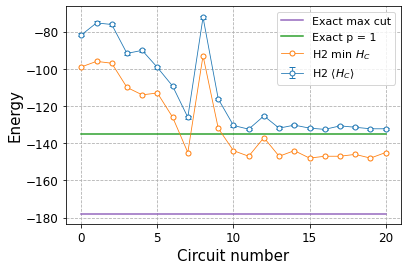

In [11]:
fig, ax = plt.subplots(1,1)
fig.set_facecolor('white')

color_list = [plt.get_cmap("tab10").colors[i] for i in range(10)]

ax.plot(line3_xvals['Exact Max Cut'], line3_yvals['Exact Max Cut'],  color=color_list[4],ls='solid')  
ax.plot(line2_xvals['p = 1 exact'], line2_yvals['p = 1 exact'],  color=color_list[2],ls='solid')     

ax.plot(line_xvals['H2 Best'], line_yvals['H2 Best'], color=color_list[1],ls='solid',marker='o',markersize=5,
            markerfacecolor=[1, 1, 1],
            markeredgecolor=color_list[1],lw=0.8)
    

ax.errorbar(xv,N130ObjectiveTrajectory,yerr=N130errs,fmt="o",markersize=5,capsize=3,ecolor=color_list[0],markerfacecolor=[1, 1, 1],markeredgecolor=color_list[0],ls = 'solid',lw=0.8)

lab = r'H2 $\langle H_C \rangle$'
lab2 = r'H2 min $H_C$'
legend = ['Exact max cut','Exact p = 1', lab2,lab]


ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Circuit number", fontsize=15)
ax.set_ylabel("Energy",  fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(list(range(0,25,5)))
ax.legend(legend, fontsize=11)

In [12]:
xv = range(len(N32ObjectiveTrajectory))
data = {'H2 Avg': {xv[i]: N32ObjectiveTrajectory[i] for i in range(len(xv))}}
QuimbBayesian = [N32_quimb_best_val_p1 for _ in xv]
QuimbBayesian2 = [N32_quimb_best_val_p2 for _ in xv]
TrueMaxCut = [-1*N32MaxCut[0] for _ in xv]

# make list for solid line in plot

line0_xvals = {'H2 Best': xv}
line0_yvals = {'H2 Best': N32BestEachEval}
line1_xvals = {'p = 1 exact': xv}
line1_yvals = {'p = 1 exact': QuimbBayesian}
line2_xvals = {'p = 2 exact': xv}
line2_yvals = {'p = 2 exact': QuimbBayesian2}
line3_xvals = {'Exact Max Cut': xv}
line3_yvals = {'Exact Max Cut': TrueMaxCut}

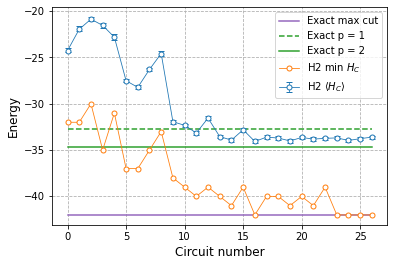

In [13]:
fig, ax = plt.subplots()
fig.set_facecolor('white')

color_list = [plt.get_cmap("tab10").colors[i] for i in range(10)]

ax.plot(line3_xvals['Exact Max Cut'], line3_yvals['Exact Max Cut'],  color=color_list[4],ls='solid')  
ax.plot(line1_xvals['p = 1 exact'], line1_yvals['p = 1 exact'], "-", color=color_list[2],ls='dashed')
ax.plot(line2_xvals['p = 2 exact'], line2_yvals['p = 2 exact'],  color=color_list[2])   

ax.plot(line0_xvals['H2 Best'], line0_yvals['H2 Best'], color=color_list[1],ls='solid',marker='o',markersize=5,
            markerfacecolor=[1, 1, 1],
            markeredgecolor=color_list[1],lw=0.8)
    

ax.errorbar(range(len(N32ObjectiveTrajectory)),N32ObjectiveTrajectory,yerr=N32errs,fmt="o",markersize=5,capsize=3,ecolor=color_list[0],markerfacecolor=[1, 1, 1],markeredgecolor=color_list[0],ls = 'solid',lw=0.8)

lab = r'H2 $\langle H_C \rangle$'
lab2 = r'H2 min $H_C$'
legend = ['Exact max cut','Exact p = 1','Exact p = 2',lab2,lab]


ax.grid(visible=True, axis="both", linestyle="--")
ax.set_xlabel("Circuit number", fontsize=12)
ax.set_ylabel("Energy",  fontsize=12)
ax.legend(legend)

The parameter space is periodic, but when we plot that, mpl is not aware of it. This causes plotting to show "large jumps" in parameter space that are actually "small jumps" across the periodic boundary. To fix this for plotting purposes, one needs to add some interpolating points at the boundary of parameter space and plot the curves disjointly, which is done below.

In [14]:
traj_periodic = [i % (np.pi / 2) for i in N130params]

In [15]:
x1 = 0
x2 = np.pi/2
y1=((traj_periodic[5][1] - traj_periodic[4][1]) / (traj_periodic[5][0] - traj_periodic[4][0] - np.pi/2)) * (x1 - traj_periodic[4][0]) + traj_periodic[4][1]
interp45a = np.array([x1,y1])
interp45b = np.array([x2,y1])
y1 = np.pi/2
y2 = 0
x1 =((traj_periodic[8][0] - traj_periodic[7][0] ) /  (traj_periodic[8][1] + np.pi/2 - traj_periodic[7][1])) * (y1 - traj_periodic[7][1]) + traj_periodic[7][0]
interp78a = np.array([x1,y1])
interp78b = np.array([x1,y2])
y1 = 0
y2 = np.pi/2
x1 =((traj_periodic[9][0] - traj_periodic[8][0] ) /  (traj_periodic[9][1] - np.pi/2 - traj_periodic[8][1])) * (y1 - traj_periodic[8][1]) + traj_periodic[8][0]
interp89a = np.array([x1,y1])
interp89b = np.array([x1,y2])
ln45a = [traj_periodic[4], interp45a]
ln45b = [interp45b,traj_periodic[5]]
ln78a = [traj_periodic[7], interp78a]
ln78b = [interp78b,traj_periodic[8]]
ln89a = [traj_periodic[8], interp89a]
ln89b = [interp89b,traj_periodic[9]]

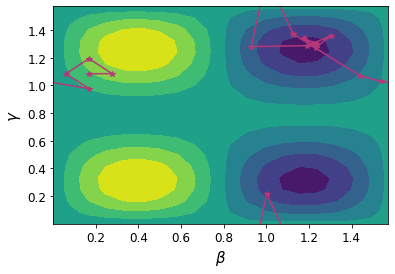

In [16]:
fig, ax = plt.subplots(1,1)

beta_range = np.linspace(1e-5,np.pi/2,20)
gamma_range = np.linspace(1e-5,np.pi/2,20)
ax.contourf(beta_range, gamma_range, np.transpose(landscape))
cmap = plt.get_cmap('magma')
ax.plot(*zip(*traj_periodic[:5]), color = cmap(0.5),marker='*')
ax.plot(*zip(*traj_periodic[5:8]), color = cmap(0.5),marker='*')
ax.plot(*zip(*traj_periodic[7:8]), color = cmap(0.5),marker='*')
ax.plot(*zip(*traj_periodic[8:9]), color = cmap(0.5),marker='*')
ax.plot(*zip(*traj_periodic[9:]), color = cmap(0.5),marker='*')
ax.plot(*zip(*ln45a), color = cmap(0.5))
ax.plot(*zip(*ln45b), color = cmap(0.5))
ax.plot(*zip(*ln78a), color = cmap(0.5))
ax.plot(*zip(*ln78b), color = cmap(0.5))
ax.plot(*zip(*ln89a), color = cmap(0.5))
ax.plot(*zip(*ln89b), color = cmap(0.5))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(r'$\gamma$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>